<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/5_3_fine_tuning_bert_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Fine-tuning ⭐

---

**PEFT** (Parameter-efficient fine-tuning)

  * What?

> A family of techniques for freezing and fine-tuning pre-trained models.

  * Idea

> Freeze as much of the model as possible, and possibly adding new parameters at critical locations.

  * Use case

> Use to train a general pre-trained model to learn a specific domain knowledge.

  * Pros & Cons:

> * Pros: train LLM with limited resources
> * Cons: difficult to generalize to new tasks

Some common PEFT techniques:

* LoRA (Low-Rank Adaptation):

Decompose weight matrices to low-rank approximations, and train those low-rank matrices.

* Adapters:

Freeze the entire model, only add small trainable layers at critical locations.

---

# ✈ Imports

In [ ]:
from transformers import BertModel, BertTokenizer
from datasets import load_dataset, DatasetDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

!pip install torchinfo
from torchinfo import summary

from typing import override

# 🔢 Hyperparameters

In [ ]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# 📂 Prepare Training Data

In [ ]:
# import BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

In [ ]:
# import IMDB dataset
dataset = load_dataset('imdb')
# only keep a sub set of data
dataset = DatasetDict({split:dataset[split].select(range(5_000, 20_000)) for split in ['train','test']})

In [ ]:
# tokenize dataset
tokenized_dataset = \
    dataset.map(lambda data: tokenizer(data['text'], max_length=512, truncation=True, padding='max_length'), batched=True)\
    .remove_columns(['text'])\
    .with_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
# Train / Test dataset
train_dataloader = DataLoader(tokenized_dataset['train'], shuffle=True, batch_size=32)
test_dataloader  = DataLoader(tokenized_dataset['test'], batch_size=32)

In [ ]:
next(iter(train_dataloader))

{'label': tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 0, 0]),
 'input_ids': tensor([[ 101, 4931, 2085,  ...,    0,    0,    0],
         [ 101, 1045, 3473,  ...,    0,    0,    0],
         [ 101, 1045, 2031,  ...,    0,    0,    0],
         ...,
         [ 101, 9145, 2000,  ...,    0,    0,    0],
         [ 101, 2763, 1996,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

# [0] 🏚 Model

In [ ]:
num_classes = 2

# use Bert model in a custom model
class BertClassificationMode(nn.Module):
  def __init__(self, bert_model, num_classes):
    super(BertClassificationMode, self).__init__()

    # Use the pre-trained BERT model
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    # final classfier layer input is 786 dimension, output is 2 dimension
    self.classifier = nn.Linear(768, num_classes)
    p = self.bert.embeddings.dropout.p
    self.dropout = nn.Dropout(p)

    # init classifier weights and biases
    nn.init.xavier_uniform_(self.classifier.weight)
    nn.init.zeros_(self.classifier.bias)


  def forward(self, input_ids, attention_mask=None, token_type_ids=None):
    bert_outputs = self.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
    )

    logits = self.classifier(self.dropout(bert_outputs.pooler_output))
    return logits


In [ ]:
model = BertClassificationMode(bert, num_classes).to(device)
model

BertClassificationMode(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

**Freeze Attention blocks and embedding layers**

In [ ]:
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for layer in model.bert.encoder.layer:
    for param in layer.attention.parameters():
        param.requires_grad = False

trainable_params = 0
frozen_params = 0

for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params += param.numel()
    else:
        frozen_params += param.numel()

total_params = trainable_params + frozen_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")
print(f"Percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

Total parameters: 109,483,778
Trainable parameters: 57,279,746
Frozen parameters: 52,204,032
Percentage of trainable parameters: 52.32%


# [1] 🔘 Fine-tuning

In [ ]:
# optimizers
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5)

In [ ]:
# loss func
loss_func = nn.CrossEntropyLoss()

In [ ]:
# init losses
train_loss = []
test_loss = []

In [ ]:
sample_size = 200

for i in range(sample_size):

  # get input data X
  X = next(iter(train_dataloader))
  X_token_ids = X['input_ids'].to(device)
  X_attention_mask = X['attention_mask'].to(device)
  X_labels = X['label'].to(device)

  # ----- Fine-tuning -----

  # clear previous gradients
  model.zero_grad(set_to_none=True)

  # forward
  logits = model(X_token_ids, X_attention_mask)
  outputLabel = torch.argmax(logits, dim=1)

  # calc loss
  loss = loss_func(logits, X_labels)

  # back propagate
  loss.backward()
  # update weights
  optimizer.step()

  # save loss
  train_loss.append(loss.item())

  # ----------------------------------------------------------------------

  # ***** Test during Fine-tuning *****
  if i % 20 == 0:
    model.eval()
    with torch.no_grad():
      # get input data X
      X = next(iter(test_dataloader))
      X_token_ids = X['input_ids'].to(device)
      X_attention_mask = X['attention_mask'].to(device)
      X_labels = X['label'].to(device)

      # forward
      logits = model(X_token_ids, X_attention_mask)
      outputLabel = torch.argmax(logits, dim=1)

      # calc loss
      loss = loss_func(logits, X_labels)

      # save loss
      test_loss.append(loss.item())

      # print progress
      print(f"Iteration {i}/{sample_size}: Train Loss = {train_loss[-1]:.4f}, Test Loss = {test_loss[-1]:.4f}")

Iteration 0/200: Train Loss = 0.1466, Test Loss = 0.1321
Iteration 20/200: Train Loss = 0.2958, Test Loss = 0.3038
Iteration 40/200: Train Loss = 0.1832, Test Loss = 0.2239
Iteration 60/200: Train Loss = 0.1833, Test Loss = 0.4912
Iteration 80/200: Train Loss = 0.1587, Test Loss = 0.3321
Iteration 100/200: Train Loss = 0.1413, Test Loss = 0.2475
Iteration 120/200: Train Loss = 0.2109, Test Loss = 0.3598
Iteration 140/200: Train Loss = 0.0940, Test Loss = 0.3060
Iteration 160/200: Train Loss = 0.0734, Test Loss = 0.1650
Iteration 180/200: Train Loss = 0.1761, Test Loss = 0.1894


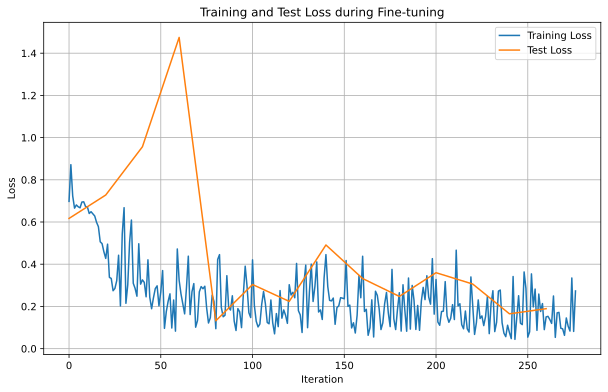

In [ ]:
# plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot([i * 20 for i in range(len(test_loss))], test_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Test Loss during Fine-tuning')
plt.legend()
plt.grid(True)
plt.show()